In [1]:
! pip install sqlalchemy pyodbc

In [2]:
import sqlalchemy
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest,RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
from textwrap import wrap
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [3]:
server = r"SAKS\SQLEXPRESS"
database = "HEALTHCARE_"
username = "Saks"
password = "Sql@2025"

In [4]:
# Creating SQLAlchemy engine using PyODBC
engine = sqlalchemy.create_engine(f"mssql+pyodbc://{server}/{database}?driver=SQL+Server&trusted_connection=yes") 

In [5]:
# Fetching all table names
query = "SELECT TABLE_NAME FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_TYPE = 'BASE TABLE'"
df_tables = pd.read_sql(query, engine)

print(df_tables)

                            TABLE_NAME
0            Medicare_Charge_Inpatient
1           Medicare_Charge_Outpatient
2   Medicare_Provider_Charge_Inpatient
3  Medicare_Provider_Charge_Outpatient
4                 Patient_history_samp
5          Review_patient_history_samp
6               Review_transaction_coo
7                      Transaction_coo
8      DRGCodes_Global_proc_id_Mapping


In [6]:
# Fetching data from a specific table
table_name = "Medicare_Charge_Inpatient"  
Medicare_Charge_Inpatient = pd.read_sql(f"SELECT * FROM {table_name}", engine)

table_name = "Medicare_Charge_Outpatient"  
Medicare_Charge_Outpatient = pd.read_sql(f"SELECT * FROM {table_name}", engine)

table_name = "Medicare_Provider_Charge_Inpatient"  
chunk_size = 5000  # Adjust based on available memory
chunks = pd.read_sql(f"SELECT * FROM {table_name}", engine, chunksize=chunk_size)
Medicare_Provider_Charge_Inpatient = pd.concat(chunks, ignore_index=True)

table_name = "Medicare_Provider_Charge_Outpatient"  
Medicare_Provider_Charge_Outpatient = pd.read_sql(f"SELECT * FROM {table_name}", engine)

table_name = "Patient_history_samp"  
chunk_size = 5000  # Adjust based on available memory
chunks = pd.read_sql(f"SELECT * FROM {table_name}", engine, chunksize=chunk_size)
Patient_history_samp = pd.concat(chunks, ignore_index=True)

table_name = "Review_patient_history_samp"  
Review_patient_history_samp = pd.read_sql(f"SELECT * FROM {table_name}", engine)

table_name = "Review_transaction_coo"  
Review_transaction_coo = pd.read_sql(f"SELECT * FROM {table_name}", engine)

table_name = "Transaction_coo"  
Transaction_coo = pd.read_sql(f"SELECT * FROM {table_name}", engine)

table_name = "DRGCodes_Global_proc_id_Mapping"  
Global_proc_id = pd.read_sql(f"SELECT * FROM {table_name}", engine)

In [7]:
Medicare_Provider_Charge_Inpatient

,DRG_Definition,Provider_Id,Provider_Name,Provider_Street_Address,Provider_City,Provider_State,Provider_Zip_Code,Hospital_Referral_Region_HRR_Description,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payments
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.078125,5777.241699,4763.736328
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.857422,5787.571289,4976.714355
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.375000,5434.958496,4453.791504
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.280273,5417.560059,4129.160156
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.277344,5658.333496,4851.444336
...,...,...,...,...,...,...,...,...,...,...,...,...
163060,948 - SIGNS & SYMPTOMS W/O MCC,670041,SETON MEDICAL CENTER WILLIAMSON,201 SETON PARKWAY,ROUND ROCK,TX,78664,TX - Austin,23,26314.390625,3806.869629,3071.391357
163061,948 - SIGNS & SYMPTOMS W/O MCC,670055,METHODIST STONE OAK HOSPITAL,1139 E SONTERRA BLVD,SAN ANTONIO,TX,78258,TX - San Antonio,11,21704.726562,4027.363525,2649.727295
163062,948 - SIGNS & SYMPTOMS W/O MCC,670056,SETON MEDICAL CENTER HAYS,6001 KYLE PKWY,KYLE,TX,78640,TX - Austin,19,39121.738281,5704.368652,4058.368408
163063,948 - SIGNS & SYMPTOMS W/O MCC,670060,TEXAS REGIONAL MEDICAL CENTER AT SUNNYVALE,231 SOUTH COLLINS ROAD,SUNNYVALE,TX,75182,TX - Dallas,11,28873.091797,7663.090820,6848.545410


In [8]:
Medicare_Provider_Charge_Inpatient.rename(columns={"Average_Total_Payments":"Average_Total_Payments_In","Provider_Name" : "Provider_Name_In","Provider_Street_Address":"Provider_Street_Address_In","Provider_City":"Provider_City_In","Provider_State":"Provider_State_In","Provider_Zip_Code":"Provider_Zip_Code_In","Hospital_Referral_Region_HRR_Description":"Hospital_Referral_Region_HRR_Description_In"},inplace=True)

Medicare_Provider_Charge_Outpatient.rename(columns={"Average_Total_Payments":"Average_Total_Payments_Out","Provider_Name" : "Provider_Name_Out","Provider_Street_Address":"Provider_Street_Address_Out","Provider_City":"Provider_City_Out","Provider_State":"Provider_State_Out","Provider_Zip_Code":"Provider_Zip_Code_Out","Hospital_Referral_Region_HRR_Description":"Hospital_Referral_Region_HRR_Description_Out"},inplace=True)

In [9]:
merged_data = Medicare_Provider_Charge_Inpatient.merge(Medicare_Provider_Charge_Outpatient, on="Provider_Id")

In [10]:
# display all the column
pd.set_option('display.max_columns', None)

Identify providers that overcharge for certain procedures or regions where procedures are too expensive.

Highest Cost Variation

Inpatient

In [11]:
cost_variance_inpatient = Medicare_Provider_Charge_Inpatient.groupby("DRG_Definition", observed=True)["Average_Covered_Charges"].agg(['mean', 'std']).reset_index()
cost_variance_inpatient["Cost_variation"] = cost_variance_inpatient["std"] / cost_variance_inpatient["mean"]

most_variable_procedure = cost_variance_inpatient.nlargest(5, "Cost_variation")[["DRG_Definition", "Cost_variation"]]

print("Most variable procedure Inpatient: \n")
most_variable_procedure


Most variable procedure Inpatient: 



,DRG_Definition,Cost_variation
95,885 - PSYCHOSES,0.717796
96,897 - ALCOHOL/DRUG ABUSE OR DEPENDENCE W/O REH...,0.633967
97,917 - POISONING & TOXIC EFFECTS OF DRUGS W MCC,0.613150
13,190 - CHRONIC OBSTRUCTIVE PULMONARY DISEASE W MCC,0.610374
12,189 - PULMONARY EDEMA & RESPIRATORY FAILURE,0.610107


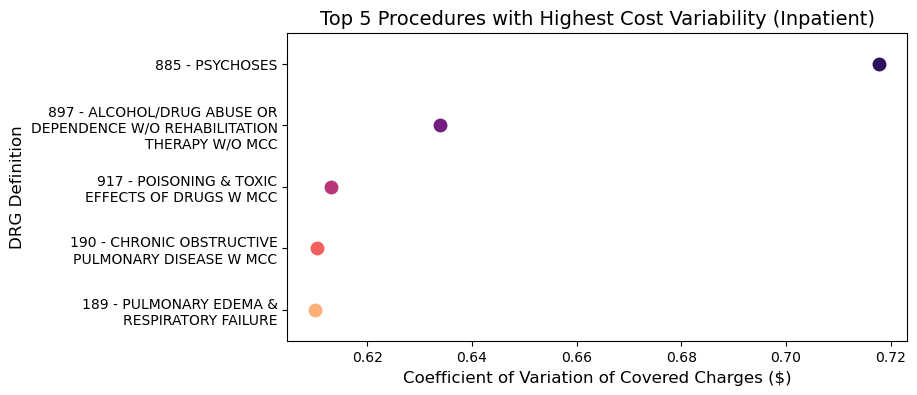

In [12]:
# Visualization
plt.figure(figsize=(8, 4))
ax = sns.stripplot(
    x="Cost_variation", 
    y="DRG_Definition", 
    hue="DRG_Definition", 
    data=most_variable_procedure, 
    size=10, 
    palette="magma"
)

plt.xlabel("Coefficient of Variation of Covered Charges ($)", fontsize=12)
plt.ylabel("DRG Definition", fontsize=12)
plt.title("Top 5 Procedures with Highest Cost Variability (Inpatient)", fontsize=14)

# **Wrap Y-axis labels for readability**
wrapped_labels = [textwrap.fill(label, width=30) for label in most_variable_procedure["DRG_Definition"]]

# **Manually set wrapped labels by adjusting tick positions**
ax.set_yticks(range(len(wrapped_labels)))  # Set tick positions manually
ax.set_yticklabels(wrapped_labels)

plt.show()


Outpatient

In [13]:
cost_variance_outpatient= Medicare_Provider_Charge_Outpatient.groupby("APC", observed=True)["Average_Estimated_Submitted_Charges"].agg(['std','mean']).reset_index()

cost_variance_outpatient['Cost_variation'] = cost_variance_outpatient["std"]/cost_variance_outpatient['mean']

most_variable_procedure_out = cost_variance_outpatient.nlargest(5, "Cost_variation")[["APC", "Cost_variation"]]

print("Most variable procedure Outpatient: \n")
most_variable_procedure_out

Most variable procedure Outpatient: 



,APC,Cost_variation
22,0604 - Level 1 Hospital Clinic Visits,1.385150
29,0698 - Level II Eye Tests & Treatments,1.310444
3,0019 - Level I Excision/ Biopsy,1.229897
28,0692 - Level II Electronic Analysis of Devices,1.128166
0,0012 - Level I Debridement & Destruction,1.050087


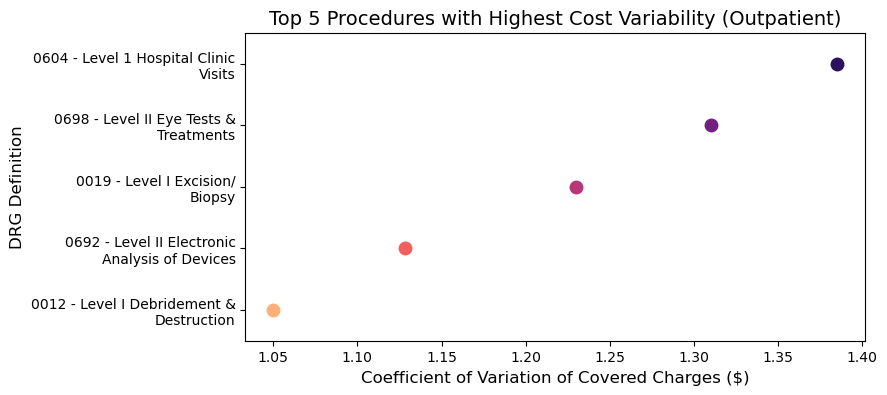

In [14]:
# Visualization
plt.figure(figsize=(8, 4))
ax = sns.stripplot(
    x="Cost_variation", 
    y="APC", 
    hue="APC", 
    data=most_variable_procedure_out, 
    size=10, 
    palette="magma"
)

plt.xlabel("Coefficient of Variation of Covered Charges ($)", fontsize=12)
plt.ylabel("DRG Definition", fontsize=12)
plt.title("Top 5 Procedures with Highest Cost Variability (Outpatient)", fontsize=14)

# **Wrap Y-axis labels for readability**
wrapped_labels = [textwrap.fill(label, width=30) for label in most_variable_procedure_out["APC"]]

# **Manually set wrapped labels by adjusting tick positions**
ax.set_yticks(range(len(wrapped_labels)))  # Set tick positions manually
ax.set_yticklabels(wrapped_labels)

plt.show()


Highest Cost claims by Provider

Inpatient

In [15]:
# Finding the highest charge for a particular procedure 
procedure_high_cost = Medicare_Provider_Charge_Inpatient.groupby("DRG_Definition")['Average_Covered_Charges'].max().reset_index()
procedure_high_cost = procedure_high_cost.rename(columns={"Average_Covered_Charges":"Max_average_Covered_Charges"})

procedure_high_cost

,DRG_Definition,Max_average_Covered_Charges
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,146892.000000
1,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,148128.437500
2,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,234912.703125
3,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,162922.500000
4,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,117831.140625
...,...,...
95,885 - PSYCHOSES,144522.671875
96,897 - ALCOHOL/DRUG ABUSE OR DEPENDENCE W/O REH...,79932.539062
97,917 - POISONING & TOXIC EFFECTS OF DRUGS W MCC,236455.906250
98,918 - POISONING & TOXIC EFFECTS OF DRUGS W/O MCC,79965.718750


In [16]:
# merging the table to get the provider who charge the highest
Medicare_Inpatient_merge = Medicare_Provider_Charge_Inpatient.merge(procedure_high_cost,on="DRG_Definition",how = "left")
Medicare_Inpatient_merge


,DRG_Definition,Provider_Id,Provider_Name_In,Provider_Street_Address_In,Provider_City_In,Provider_State_In,Provider_Zip_Code_In,Hospital_Referral_Region_HRR_Description_In,Total_Discharges,Average_Covered_Charges,Average_Total_Payments_In,Average_Medicare_Payments,Max_average_Covered_Charges
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.078125,5777.241699,4763.736328,146892.0
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.857422,5787.571289,4976.714355,146892.0
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.375000,5434.958496,4453.791504,146892.0
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.280273,5417.560059,4129.160156,146892.0
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.277344,5658.333496,4851.444336,146892.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
163060,948 - SIGNS & SYMPTOMS W/O MCC,670041,SETON MEDICAL CENTER WILLIAMSON,201 SETON PARKWAY,ROUND ROCK,TX,78664,TX - Austin,23,26314.390625,3806.869629,3071.391357,84846.5
163061,948 - SIGNS & SYMPTOMS W/O MCC,670055,METHODIST STONE OAK HOSPITAL,1139 E SONTERRA BLVD,SAN ANTONIO,TX,78258,TX - San Antonio,11,21704.726562,4027.363525,2649.727295,84846.5
163062,948 - SIGNS & SYMPTOMS W/O MCC,670056,SETON MEDICAL CENTER HAYS,6001 KYLE PKWY,KYLE,TX,78640,TX - Austin,19,39121.738281,5704.368652,4058.368408,84846.5
163063,948 - SIGNS & SYMPTOMS W/O MCC,670060,TEXAS REGIONAL MEDICAL CENTER AT SUNNYVALE,231 SOUTH COLLINS ROAD,SUNNYVALE,TX,75182,TX - Dallas,11,28873.091797,7663.090820,6848.545410,84846.5


In [17]:
# defining a function to flag the max_covered_charge
def flag(patient):
    if ((patient['Max_average_Covered_Charges']==patient['Average_Covered_Charges'])):
        return 1
    else:
        return 0
    
Medicare_Inpatient_merge['Flag_max'] = Medicare_Inpatient_merge.apply(flag,axis=1)
Medicare_Inpatient_merge[Medicare_Inpatient_merge['Flag_max']==1]

,DRG_Definition,Provider_Id,Provider_Name_In,Provider_Street_Address_In,Provider_City_In,Provider_State_In,Provider_Zip_Code_In,Hospital_Referral_Region_HRR_Description_In,Total_Discharges,Average_Covered_Charges,Average_Total_Payments_In,Average_Medicare_Payments,Max_average_Covered_Charges,Flag_max
123,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,50599,UNIVERSITY OF CALIFORNIA DAVIS MEDICAL CENTER,2315 STOCKTON BOULEVARD,SACRAMENTO,CA,95817,CA - Sacramento,13,146892.000000,11514.384766,9758.307617,146892.000000,1
1191,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,50441,STANFORD HOSPITAL,300 PASTEUR DRIVE,STANFORD,CA,94305,CA - San Mateo County,16,148128.437500,25519.437500,22553.562500,148128.437500,1
3621,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,390290,HAHNEMANN UNIVERSITY HOSPITAL,230 NORTH BROAD STREET,PHILADELPHIA,PA,19102,PA - Philadelphia,20,234912.703125,23126.150391,22126.300781,234912.703125,1
5234,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,310025,BAYONNE HOSPITAL CENTER,29 EAST 29TH ST,BAYONNE,NJ,7002,NJ - Newark,24,162922.500000,18080.416016,6938.500000,162922.500000,1
7652,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,390290,HAHNEMANN UNIVERSITY HOSPITAL,230 NORTH BROAD STREET,PHILADELPHIA,PA,19102,PA - Philadelphia,14,117831.140625,8296.000000,7251.714355,117831.140625,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157581,885 - PSYCHOSES,50373,LAC+USC MEDICAL CENTER,1200 N STATE ST,LOS ANGELES,CA,90033,CA - Los Angeles,12,144522.671875,25270.166016,23265.083984,144522.671875,1
158907,897 - ALCOHOL/DRUG ABUSE OR DEPENDENCE W/O REH...,390290,HAHNEMANN UNIVERSITY HOSPITAL,230 NORTH BROAD STREET,PHILADELPHIA,PA,19102,PA - Philadelphia,13,79932.539062,6591.000000,5554.692383,79932.539062,1
159137,917 - POISONING & TOXIC EFFECTS OF DRUGS W MCC,50367,NORTHBAY MEDICAL CENTER,1200 B GALE WILSON BLVD,FAIRFIELD,CA,94533,CA - Contra Costa County,11,236455.906250,27860.544922,26940.181641,236455.906250,1
160039,918 - POISONING & TOXIC EFFECTS OF DRUGS W/O MCC,50441,STANFORD HOSPITAL,300 PASTEUR DRIVE,STANFORD,CA,94305,CA - San Mateo County,25,79965.718750,10312.799805,9728.000000,79965.718750,1


In [18]:
# print the Highest cost claimed by provider 
Highest_cost_claim_by_provider  = Medicare_Inpatient_merge.loc[Medicare_Inpatient_merge['Flag_max']==1,["DRG_Definition",'Provider_Id',"Max_average_Covered_Charges"]]

print("Highest cost claimed by provider for a particular Inpatient procedure : \n")
Highest_cost_claim_by_provider.sort_values(by="Max_average_Covered_Charges",ascending=False).head(10)

Highest cost claimed by provider for a particular Inpatient procedure : 



,DRG_Definition,Provider_Id,Max_average_Covered_Charges
39562,207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATO...,50441,929118.93750
151390,870 - SEPTICEMIA OR SEVERE SEPSIS W MV 96+ HOURS,50441,637377.68750
150009,853 - INFECTIOUS & PARASITIC DISEASES W O.R. P...,50195,576296.00000
87016,329 - MAJOR SMALL & LARGE BOWEL PROCEDURES W MCC,50464,557900.75000
109766,460 - SPINAL FUSION EXCEPT CERVICAL W/O MCC,310061,471120.84375
50787,252 - OTHER VASCULAR PROCEDURES W MCC,390180,389476.28125
57804,"286 - CIRCULATORY DISORDERS EXCEPT AMI, W CARD...",50441,351798.43750
45972,246 - PERC CARDIOVASC PROC W DRUG-ELUTING STEN...,50289,331808.96875
114959,480 - HIP & FEMUR PROCEDURES EXCEPT MAJOR JOIN...,50441,324133.75000
111064,469 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,390180,321918.21875


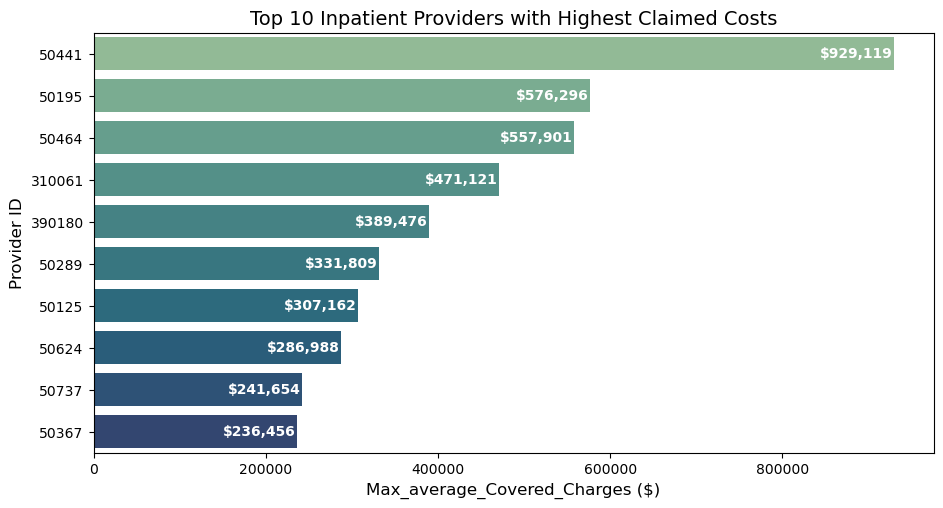

In [19]:
# Visualization
# Ensure Provider_Id is a string
Highest_cost_claim_by_provider["Provider_Id"] = Highest_cost_claim_by_provider["Provider_Id"].astype(str)

# Select top 10 providers (remove duplicates if needed)
top_providers = (
    Highest_cost_claim_by_provider.sort_values(by="Max_average_Covered_Charges", ascending=False)
    .drop_duplicates(subset=["Provider_Id"])  # Ensure unique Provider IDs
    .head(10)
)

# Adjust figure size
fig, ax = plt.subplots(figsize=(14, 6), dpi=100)

# Create barplot with hue
sns.barplot(
    x="Max_average_Covered_Charges", 
    y="Provider_Id", 
    hue="Provider_Id", 
    data=top_providers, 
    palette="crest",
    errorbar=None,
    legend=False, 
    ax=ax
)

# Add data labels dynamically
for index, value in enumerate(top_providers["Max_average_Covered_Charges"]):
    text_x = value - 1500 
    text_align = 'right'
    
    # If bar is too short, move text outside
    if value < top_providers["Max_average_Covered_Charges"].max() * 0.15:
        text_x = value + 500  
        text_align = 'left'
    
    text_color = 'white' if text_align == 'right' else 'black'  # Ensure contrast

    ax.text(text_x,  
            index, 
            f'${value:,.0f}', 
            va='center', 
            ha=text_align, 
            fontsize=10, 
            color=text_color, 
            fontweight='bold')

# Labels and Title
plt.xlabel("Max_average_Covered_Charges ($)", fontsize=12)
plt.ylabel("Provider ID", fontsize=12)
plt.title("Top 10 Inpatient Providers with Highest Claimed Costs", fontsize=14)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Wrap long y-axis labels
wrapped_labels = ["\n".join(wrap(str(label), 10)) for label in top_providers["Provider_Id"]]
ax.set_yticks(range(len(wrapped_labels)))  
ax.set_yticklabels(wrapped_labels)  

# Adjust layout
plt.subplots_adjust(left=0.3, right=0.9, top=0.9, bottom=0.2)

plt.show()

Outpatient

In [20]:
# Finding the highest charge for a particular procedure 
procedure_high_cost_out = Medicare_Provider_Charge_Outpatient.groupby("APC")['Average_Estimated_Submitted_Charges'].max().reset_index()
procedure_high_cost_out = procedure_high_cost_out.rename(columns={"Average_Estimated_Submitted_Charges":"Max_estimated_Charges"})

# merging the table to get the provider who charge the highest
Medicare_Outpatient_merge= Medicare_Provider_Charge_Outpatient.merge(procedure_high_cost_out,on="APC",how = "left")

# defining a function to flag the max_covered_charge
def flag_1(Medicare_Outpatient_merge):
    if ((Medicare_Outpatient_merge['Max_estimated_Charges']==Medicare_Outpatient_merge['Average_Estimated_Submitted_Charges'])):
        return 1
    else:
        return 0
    
Medicare_Outpatient_merge['Flag_max'] = Medicare_Outpatient_merge.apply(flag_1,axis=1)

# print the Highest cost claimed by provider 
Highest_cost_claim_by_provider_OUT  = Medicare_Outpatient_merge.loc[Medicare_Outpatient_merge['Flag_max']==1,["APC","Provider_Id","Max_estimated_Charges"]]

print("Highest cost claimed by provider for a particular Outpatient procedure : \n")
Highest_cost_claim_by_provider_OUT.sort_values(by='Max_estimated_Charges',ascending=False).head(10)

Highest cost claimed by provider for a particular Outpatient procedure : 



,APC,Provider_Id,Max_estimated_Charges
4983,0074 - Level IV Endoscopy Upper Airway,100223,32105.636719
3336,0019 - Level I Excision/ Biopsy,50739,26466.644531
3874,0020 - Level II Excision/ Biopsy,50678,19018.408203
31746,0377 - Level II Cardiac Imaging,100223,18681.970703
13181,0207 - Level III Nerve Injections,310118,17183.763672
15199,"0209 - Level II Extended EEG, Sleep, and Cardi...",330214,16080.900391
9539,0203 - Level IV Nerve Injections,100234,15461.359375
24918,0270 - Level III Echocardiogram Without Contrast,100236,13984.786133
27406,0336 - Magnetic Resonance Imaging and Magnetic...,310081,13259.000000
23976,0269 - Level II Echocardiogram Without Contrast,390180,11451.318359


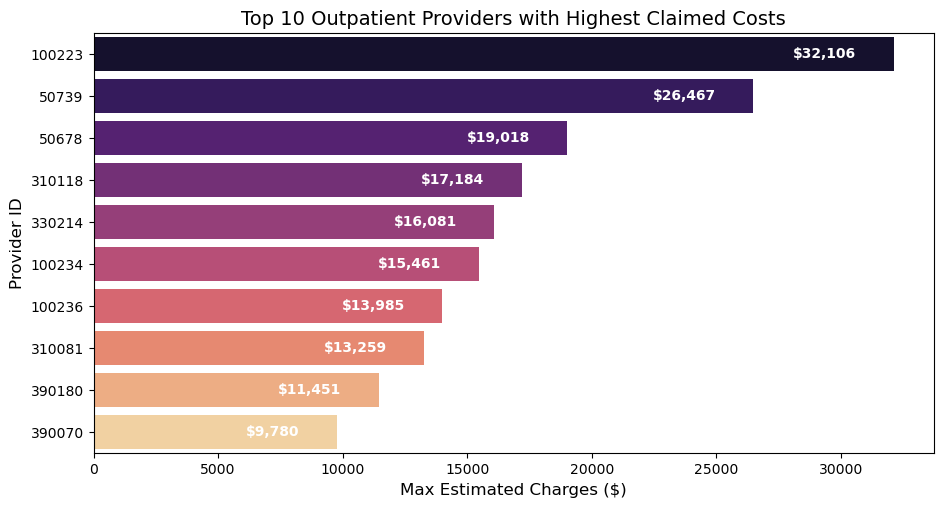

In [21]:
# Visualization
# Ensure Provider_Id is a string
Highest_cost_claim_by_provider_OUT["Provider_Id"] = Highest_cost_claim_by_provider_OUT["Provider_Id"].astype(str)

# Select top 10 providers (remove duplicates if needed)
top_providers = (
    Highest_cost_claim_by_provider_OUT.sort_values(by="Max_estimated_Charges", ascending=False)
    .drop_duplicates(subset=["Provider_Id"])  # Ensure unique Provider IDs
    .head(10)
)

# Adjust figure size
fig, ax = plt.subplots(figsize=(14, 6), dpi=100)

# Create barplot with hue
sns.barplot(
    x="Max_estimated_Charges", 
    y="Provider_Id", 
    hue="Provider_Id", 
    data=top_providers, 
    palette="magma",
    errorbar=None,
    legend=False, 
    ax=ax
)

# Add data labels dynamically
for index, value in enumerate(top_providers["Max_estimated_Charges"]):
    text_x = value - 1500 
    text_align = 'right'
    
    # If bar is too short, move text outside
    if value < top_providers["Max_estimated_Charges"].max() * 0.15:
        text_x = value + 500  
        text_align = 'left'
    
    text_color = 'white' if text_align == 'right' else 'black'  # Ensure contrast

    ax.text(text_x,  
            index, 
            f'${value:,.0f}', 
            va='center', 
            ha=text_align, 
            fontsize=10, 
            color=text_color, 
            fontweight='bold')

# Labels and Title
plt.xlabel("Max Estimated Charges ($)", fontsize=12)
plt.ylabel("Provider ID", fontsize=12)
plt.title("Top 10 Outpatient Providers with Highest Claimed Costs", fontsize=14)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Wrap long y-axis labels
wrapped_labels = ["\n".join(wrap(str(label), 10)) for label in top_providers["Provider_Id"]]
ax.set_yticks(range(len(wrapped_labels)))  
ax.set_yticklabels(wrapped_labels)  

# Adjust layout
plt.subplots_adjust(left=0.3, right=0.9, top=0.9, bottom=0.2)

plt.show()


 Highest Cost Calim by Region

Inpatient

In [22]:
# print the Highest cost claimed by region 
Highest_cost_claim_by_region_in  = Medicare_Inpatient_merge.loc[Medicare_Inpatient_merge['Flag_max']==1,["DRG_Definition",'Hospital_Referral_Region_HRR_Description_In',"Max_average_Covered_Charges"]]

Highest_cost_claim_by_region_in['Procedure_&_Hospital_region'] = Highest_cost_claim_by_region_in['DRG_Definition']+" "+"@"+" " +Highest_cost_claim_by_region_in['Hospital_Referral_Region_HRR_Description_In']

print("Highest cost claimed by Region for a particular Inpatient Procedure : \n")
Highest_cost_claim_by_region_in

Highest cost claimed by Region for a particular Inpatient Procedure : 



,DRG_Definition,Hospital_Referral_Region_HRR_Description_In,Max_average_Covered_Charges,Procedure_&_Hospital_region
123,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,CA - Sacramento,146892.000000,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC @ CA ...
1191,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,CA - San Mateo County,148128.437500,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...
3621,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,PA - Philadelphia,234912.703125,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...
5234,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,NJ - Newark,162922.500000,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...
7652,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,PA - Philadelphia,117831.140625,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...
...,...,...,...,...
157581,885 - PSYCHOSES,CA - Los Angeles,144522.671875,885 - PSYCHOSES @ CA - Los Angeles
158907,897 - ALCOHOL/DRUG ABUSE OR DEPENDENCE W/O REH...,PA - Philadelphia,79932.539062,897 - ALCOHOL/DRUG ABUSE OR DEPENDENCE W/O REH...
159137,917 - POISONING & TOXIC EFFECTS OF DRUGS W MCC,CA - Contra Costa County,236455.906250,917 - POISONING & TOXIC EFFECTS OF DRUGS W MCC...
160039,918 - POISONING & TOXIC EFFECTS OF DRUGS W/O MCC,CA - San Mateo County,79965.718750,918 - POISONING & TOXIC EFFECTS OF DRUGS W/O M...


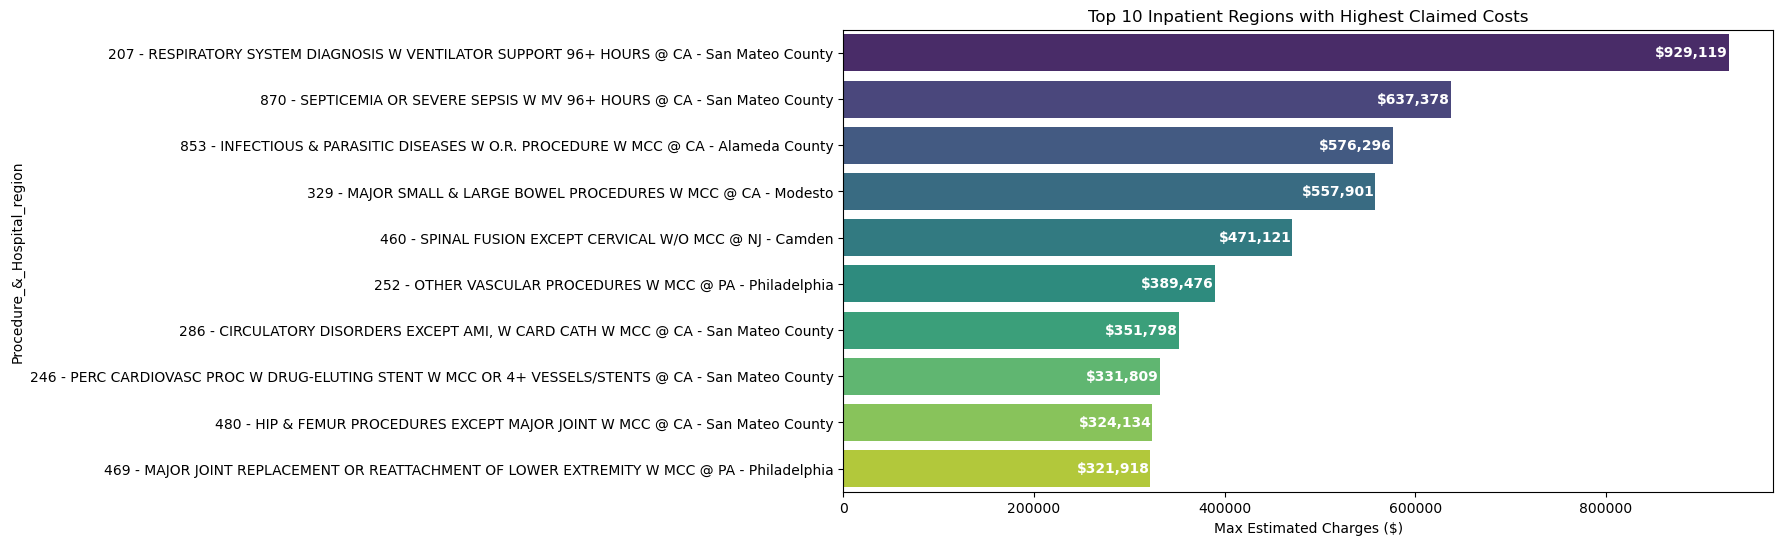

In [23]:
# Sort and select top 10 regions
top_regions = Highest_cost_claim_by_region_in.sort_values(by="Max_average_Covered_Charges", ascending=False).head(10)

plt.figure(figsize=(12, 6))
ax  = sns.barplot(x="Max_average_Covered_Charges", 
            y="Procedure_&_Hospital_region", 
            data=top_regions, 
            hue="Procedure_&_Hospital_region", 
            palette="viridis",
            legend=False,
            errorbar=None) 

# Add data labels
for index, value in enumerate(top_regions["Max_average_Covered_Charges"]):
    ax.text(value - 1000, index, f'${value:,.0f}', va='center', ha='right', fontsize=10, color='white', fontweight='bold')

plt.xlabel("Max Estimated Charges ($)")
plt.ylabel("Procedure_&_Hospital_region")
plt.title("Top 10 Inpatient Regions with Highest Claimed Costs")
plt.show()


Outpatient

In [24]:
# print the Highest cost claimed by region 
Highest_cost_claim_by_region  = Medicare_Outpatient_merge.loc[Medicare_Outpatient_merge['Flag_max']==1,["APC",'Hospital_Referral_Region_HRR_Description_Out',"Max_estimated_Charges"]]

Highest_cost_claim_by_region['Procedure_&_Hospital_region'] = Highest_cost_claim_by_region['APC']+" "+"@"+" " +Highest_cost_claim_by_region['Hospital_Referral_Region_HRR_Description_Out']

print("Highest cost claimed by Region for a particular Outpatient Procedure : \n")
Highest_cost_claim_by_region

Highest cost claimed by Region for a particular Outpatient Procedure : 



,APC,Hospital_Referral_Region_HRR_Description_Out,Max_estimated_Charges,Procedure_&_Hospital_region
157,0012 - Level I Debridement & Destruction,NE - Omaha,841.900024,0012 - Level I Debridement & Destruction @ NE ...
315,0013 - Level II Debridement & Destruction,AL - Birmingham,5231.000000,0013 - Level II Debridement & Destruction @ AL...
2520,0015 - Level III Debridement & Destruction,MO - Kansas City,3080.849609,0015 - Level III Debridement & Destruction @ M...
3336,0019 - Level I Excision/ Biopsy,CA - Los Angeles,26466.644531,0019 - Level I Excision/ Biopsy @ CA - Los Ang...
3874,0020 - Level II Excision/ Biopsy,CA - Orange County,19018.408203,0020 - Level II Excision/ Biopsy @ CA - Orange...
4848,0073 - Level III Endoscopy Upper Airway,MA - Boston,2771.000000,0073 - Level III Endoscopy Upper Airway @ MA -...
4983,0074 - Level IV Endoscopy Upper Airway,FL - Pensacola,32105.636719,0074 - Level IV Endoscopy Upper Airway @ FL - ...
5551,0078 - Level III Pulmonary Treatment,CA - Los Angeles,7098.950195,0078 - Level III Pulmonary Treatment @ CA - Lo...
9095,0096 - Level II Noninvasive Physiologic Studies,NC - Charlotte,5362.704102,0096 - Level II Noninvasive Physiologic Studie...
9539,0203 - Level IV Nerve Injections,FL - Fort Lauderdale,15461.359375,0203 - Level IV Nerve Injections @ FL - Fort L...


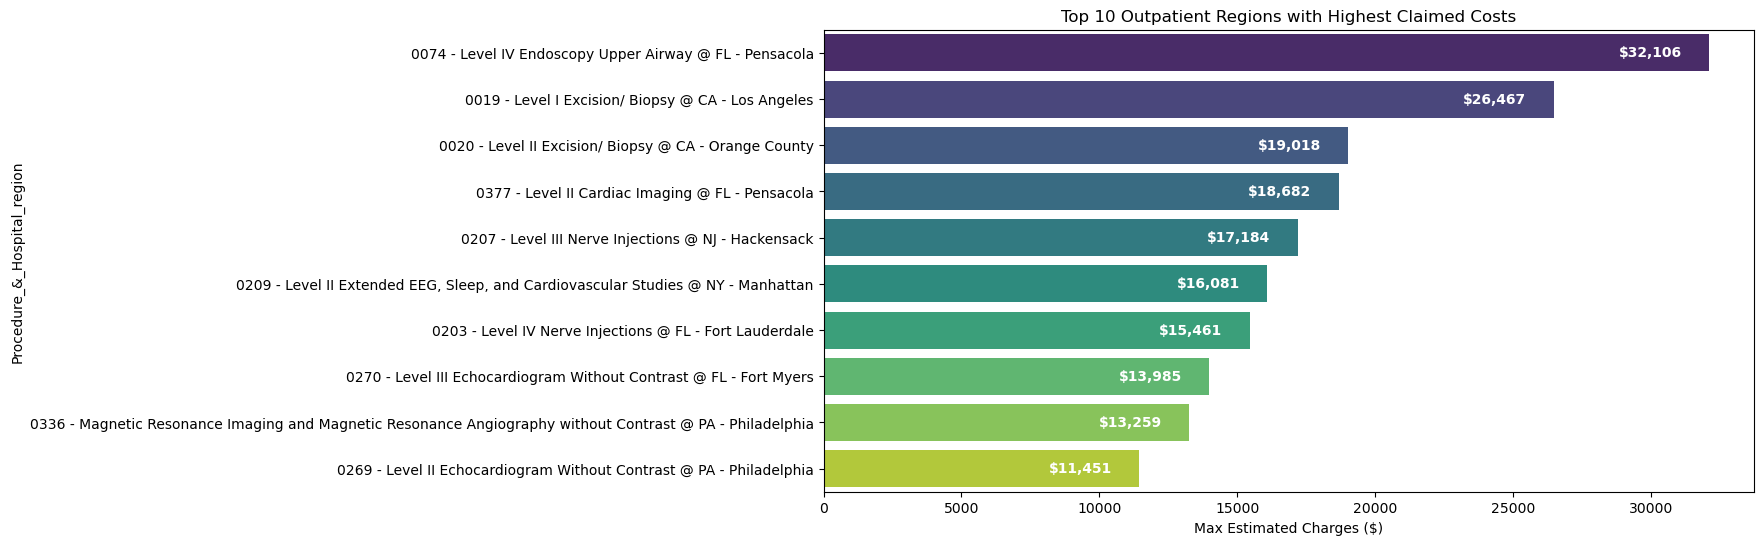

In [25]:
# Sort and select top 10 regions
top_regions = Highest_cost_claim_by_region.sort_values(by="Max_estimated_Charges", ascending=False).head(10)

plt.figure(figsize=(12, 6))
ax  = sns.barplot(x="Max_estimated_Charges", 
            y="Procedure_&_Hospital_region", 
            data=top_regions, 
            hue="Procedure_&_Hospital_region", 
            palette="viridis",
            legend=False,
            errorbar=None) 

# Add data labels
for index, value in enumerate(top_regions["Max_estimated_Charges"]):
    ax.text(value - 1000, index, f'${value:,.0f}', va='center', ha='right', fontsize=10, color='white', fontweight='bold')

plt.xlabel("Max Estimated Charges ($)")
plt.ylabel("Procedure_&_Hospital_region")
plt.title("Top 10 Outpatient Regions with Highest Claimed Costs")
plt.show()


Highest Number of Procedures and Largest Differences between Claims and Reimbursements


Inpatient

In [26]:
# Calculate claim difference
Medicare_Provider_Charge_Inpatient["claim_differnce"] = Medicare_Provider_Charge_Inpatient["Average_Covered_Charges"] - Medicare_Provider_Charge_Inpatient["Average_Total_Payments_In"]

# Procedure occurnace count
procedure_counts = Medicare_Provider_Charge_Inpatient["DRG_Definition"].value_counts().reset_index()
procedure_counts.columns = ["DRG_Definition", "procedure_count"]

# Find the max claim difference for each procedure
max_claims = Medicare_Provider_Charge_Inpatient.groupby("DRG_Definition")["claim_differnce"].max().reset_index()
max_claims.rename(columns={"claim_differnce": "Max_claim_differnce"}, inplace=True)

# Merge both datasets
final_df_in = procedure_counts.merge(max_claims, on="DRG_Definition", how="left")

# Rank based on both criteria
final_df_in["Rank"] = final_df_in["procedure_count"] * final_df_in["Max_claim_differnce"]


final_df_in.sort_values(by="Rank",ascending=False)

# explanation - First procedure is performed 1163 times accros all the providers and have the max claim difference of 79891.18 and accordingly it is ranks the highest because it's Frequency rate and max_claim_difference is high


,DRG_Definition,procedure_count,Max_claim_differnce,Rank
63,207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATO...,1163,798910.187500,9.291325e+08
50,329 - MAJOR SMALL & LARGE BOWEL PROCEDURES W MCC,1476,504432.917969,7.445430e+08
57,853 - INFECTIOUS & PARASITIC DISEASES W O.R. P...,1376,490998.312500,6.756137e+08
58,460 - SPINAL FUSION EXCEPT CERVICAL W/O MCC,1332,440405.890625,5.866206e+08
7,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,2750,202870.212891,5.578931e+08
...,...,...,...,...
68,305 - HYPERTENSION W/O MCC,1129,61753.052734,6.971920e+07
90,897 - ALCOHOL/DRUG ABUSE OR DEPENDENCE W/O REH...,906,73341.539062,6.644743e+07
66,536 - FRACTURES OF HIP & PELVIS W/O MCC,1142,57734.377930,6.593266e+07
74,684 - RENAL FAILURE W/O CC/MCC,1008,60831.532715,6.131818e+07


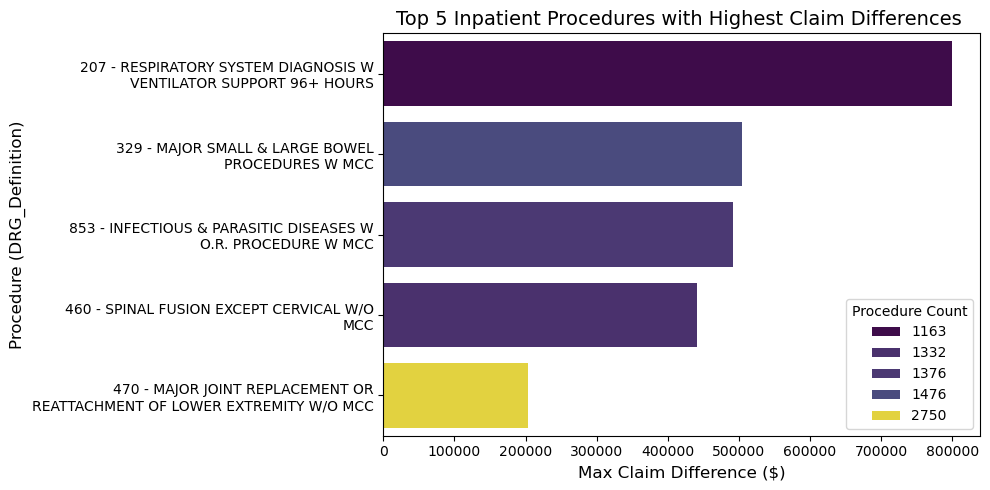

In [27]:
# Visualization
# Select Top 5 Procedures and Sort in Descending Order
top_5 = final_df_in.nlargest(5, "Rank").sort_values(by="Rank", ascending=False)

# Function to wrap text
def wrap_labels(labels, width=40):
    return ['\n'.join(textwrap.wrap(label, width)) for label in labels]

# Apply Wrapping to DRG_Definition Names
top_5["DRG_Definition"] = wrap_labels(top_5["DRG_Definition"])

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x="Max_claim_differnce", y="DRG_Definition", data=top_5, hue="procedure_count", palette="viridis")

# Labels and Title
plt.xlabel("Max Claim Difference ($)", fontsize=12)
plt.ylabel("Procedure (DRG_Definition)", fontsize=12)
plt.title("Top 5 Inpatient Procedures with Highest Claim Differences ", fontsize=14)
plt.legend(title="Procedure Count")

# Adjust Layout to Fit Text
plt.tight_layout()

# Display
plt.show()


Outpatient

In [28]:
#  Calculate claim difference
Medicare_Provider_Charge_Outpatient["claim_differnce"] = Medicare_Provider_Charge_Outpatient["Average_Estimated_Submitted_Charges"] - Medicare_Provider_Charge_Outpatient["Average_Total_Payments_Out"]
Medicare_Provider_Charge_Outpatient.head(1)

# Procedure occurance count
procedure_counts = Medicare_Provider_Charge_Outpatient["APC"].value_counts().reset_index()
procedure_counts.columns = ["APC", "procedure_count"]

# Find the max claim difference for each procedure
max_claims = Medicare_Provider_Charge_Outpatient.groupby("APC")["claim_differnce"].max().reset_index()
max_claims.rename(columns={"claim_differnce": "Max_claim_differnce"}, inplace=True)
max_claims

# Merge both datasets
final_df_out = procedure_counts.merge(max_claims, on="APC", how="left")

# Rank based on both criteria
final_df_out["Rank"] = final_df_out["procedure_count"] * final_df_out["Max_claim_differnce"]

final_df_out.sort_values(by="Rank",ascending=False).head(5)

,APC,procedure_count,Max_claim_differnce,Rank
4,0377 - Level II Cardiac Imaging,2564,17999.718079,4.615128e+07
2,0336 - Magnetic Resonance Imaging and Magnetic...,2855,12894.865784,3.681484e+07
9,0207 - Level III Nerve Injections,2002,16569.667358,3.317247e+07
1,0269 - Level II Echocardiogram Without Contrast,2898,11034.698517,3.197856e+07
10,"0209 - Level II Extended EEG, Sleep, and Cardi...",1967,15153.880371,2.980768e+07


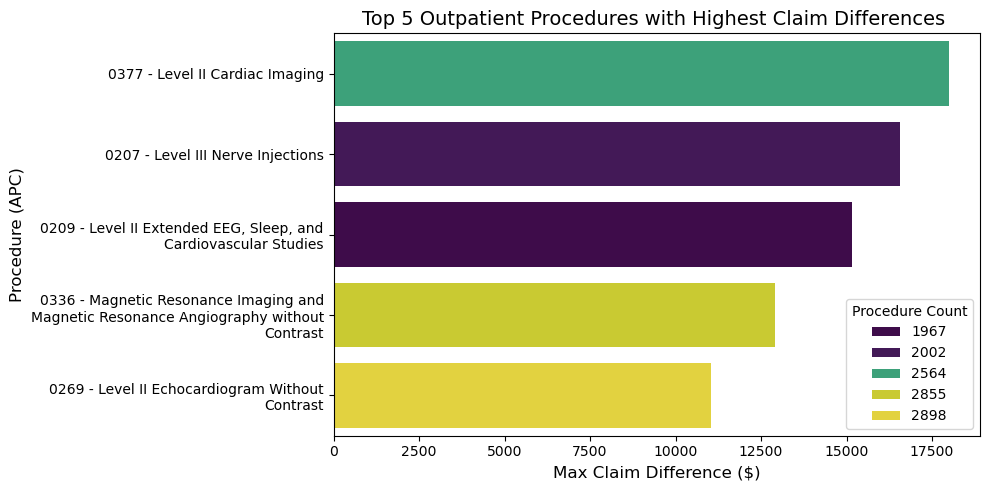

In [29]:
# Visualization
# Select Top 5 Procedures and Sort in Descending Order
top_5 = final_df_out.nlargest(5, "Rank").sort_values(by="Max_claim_differnce", ascending=False)


# Function to wrap text
def wrap_labels(labels, width=40):
    return ['\n'.join(textwrap.wrap(label, width)) for label in labels]

# Apply Wrapping to APC Names
top_5["APC"] = wrap_labels(top_5["APC"])

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x="Max_claim_differnce", y="APC", data=top_5, hue="procedure_count", palette="viridis")

# Labels and Title
plt.xlabel("Max Claim Difference ($)", fontsize=12)
plt.ylabel("Procedure (APC)", fontsize=12)
plt.title("Top 5 Outpatient Procedures with Highest Claim Differences ", fontsize=14)
plt.legend(title="Procedure Count")

# Adjust Layout to Fit Text
plt.tight_layout()

# Display
plt.show()


# Part 2

Finding 3 Providers least like others

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Select numerical features
numerical_cols = [
    "Total_Discharges", "Average_Covered_Charges", "Average_Total_Payments_In",
    "Average_Medicare_Payments", "claim_differnce"
]

df_selected = Medicare_Provider_Charge_Inpatient[numerical_cols]


# Fill missing values with median 
df_selected = df_selected.fillna(df_selected.median())

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_selected)


# PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)


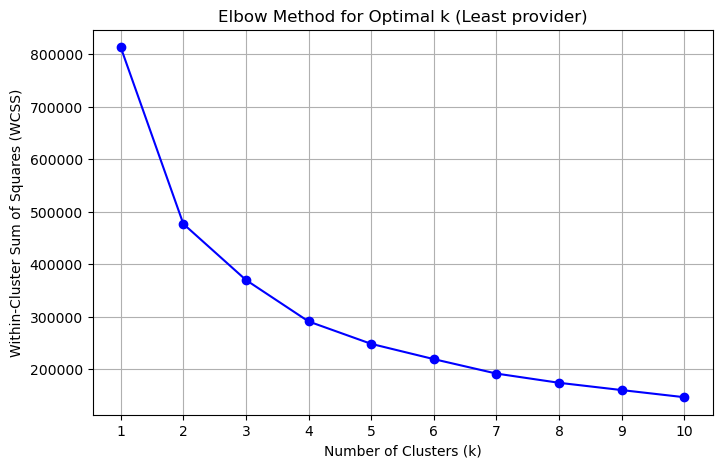

In [31]:
k_values = range(1, 11)

# Compute WCSS for each k
wcss = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)  # WCSS (Sum of Squared Distances)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k (Least provider)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [81]:
from joblib import parallel_backend
from sklearn.metrics import silhouette_score


In [82]:
silhouette_scores = []
k_values = range(2, 11)

with parallel_backend('threading'):
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        silhouette_scores.append(score)

In [78]:
from sklearn.utils import shuffle

with parallel_backend('threading'):
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_pca)
        
        # Use only a sample of data for silhouette score
        X_sampled, labels_sampled = shuffle(X_pca, labels, random_state=42, n_samples=500)  
        score = silhouette_score(X_sampled, labels_sampled)
        
        silhouette_scores.append(score)

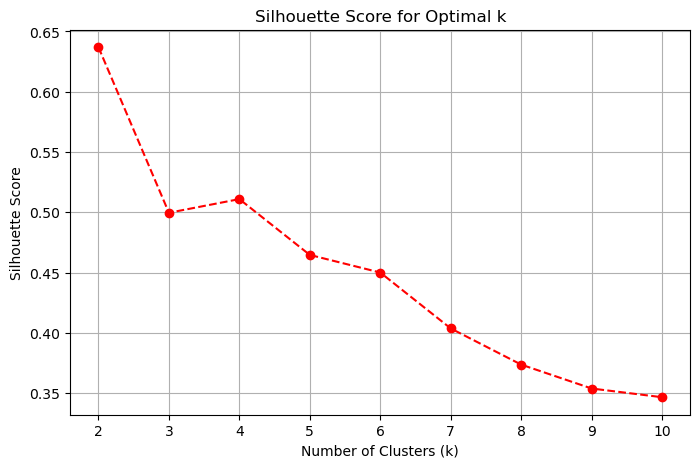

Optimal number of clusters based on silhouette score: 2


In [79]:
# Plot Silhouette Score vs. Number of Clusters
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='--', color='r')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal k")
plt.grid(True)
plt.show()

# Find the optimal k
optimal_k = k_values[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on silhouette score: {optimal_k}")

In [33]:
kmeans = KMeans(n_clusters=4, random_state=42)
Medicare_Provider_Charge_Inpatient["Cluster"] = kmeans.fit_predict(X_pca)

# Compute distance from cluster centers
distances = kmeans.transform(X_pca).min(axis=1)
Medicare_Provider_Charge_Inpatient["DistanceToCenter"] = distances

# Select 3 least similar providers
least_similar_providers = Medicare_Provider_Charge_Inpatient.nlargest(3, "DistanceToCenter")

print("Least Similar Providers:")
least_similar_providers[["Provider_Name_In", "DistanceToCenter"]]


Least Similar Providers:


,Provider_Name_In,DistanceToCenter
112966,HOSPITAL FOR SPECIAL SURGERY,62.307154
39562,STANFORD HOSPITAL,38.293925
39529,WASHINGTON HOSPITAL,34.865948


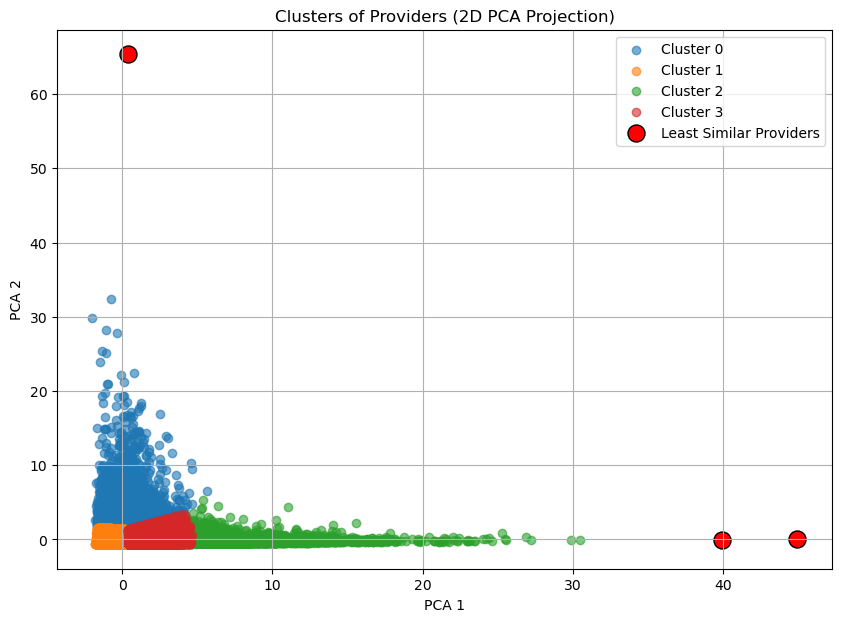

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

# Scatter plot for each cluster
for cluster in range(4):
    cluster_points = X_pca[Medicare_Provider_Charge_Inpatient["Cluster"] == cluster, :2]  
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', alpha=0.6)

# Highlight least similar providers
least_similar_indices = Medicare_Provider_Charge_Inpatient["DistanceToCenter"].nlargest(3).index
least_similar_points = X_pca[least_similar_indices, :2]  
plt.scatter(least_similar_points[:, 0], least_similar_points[:, 1], 
            color='red', edgecolors='black', s=150, label='Least Similar Providers')

# Labels
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Clusters of Providers (2D PCA Projection)")
plt.legend()
plt.grid(True)
plt.show()


# Region

In [35]:
df_regions = Medicare_Provider_Charge_Inpatient.groupby("Hospital_Referral_Region_HRR_Description_In")[numerical_cols].mean().reset_index()

# Standardize the regional data
X_regions_scaled = scaler.fit_transform(df_regions[numerical_cols])
X_pca_ = pca.fit_transform(X_regions_scaled)

In [36]:
import os
os.environ["OMP_NUM_THREADS"] = "2"

c:\Users\LENOVO\anaconda3_new\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\LENOVO\anaconda3_new\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\LENOVO\anaconda3_new\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\LENOVO\anaconda3_new\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a m

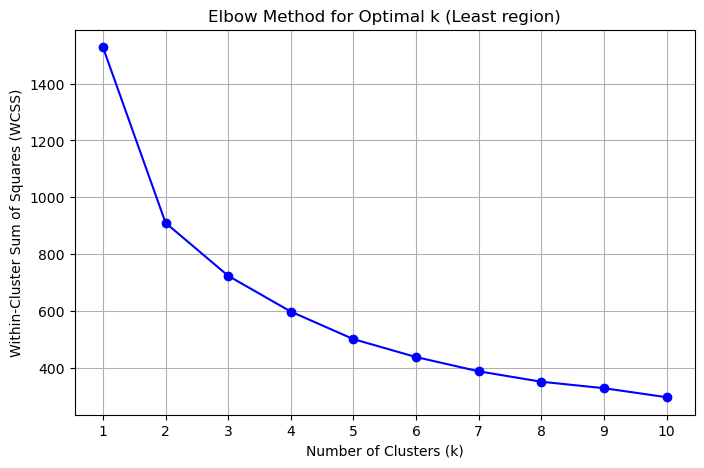

In [37]:
k_values = range(1, 11)

# Compute WCSS for each k
wcss = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca_)
    wcss.append(kmeans.inertia_)  # WCSS (Sum of Squared Distances)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k (Least region)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

c:\Users\LENOVO\anaconda3_new\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\LENOVO\anaconda3_new\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\LENOVO\anaconda3_new\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\LENOVO\anaconda3_new\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a m

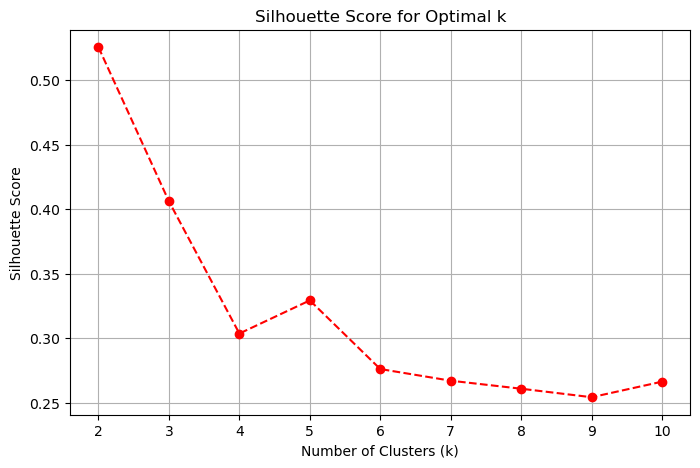

Optimal number of clusters based on silhouette score: 2


In [72]:
from joblib import parallel_backend

silhouette_scores = []
k_values = range(2, 11)

with parallel_backend('threading'):
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_pca_)
        score = silhouette_score(X_pca_, labels)
        silhouette_scores.append(score)

# Plot Silhouette Score vs. Number of Clusters
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='--', color='r')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal k")
plt.grid(True)
plt.show()

# Find the optimal k
optimal_k = k_values[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on silhouette score: {optimal_k}")


In [40]:
kmeans = KMeans(n_clusters=2, random_state=42)
df_regions["Cluster"] = kmeans.fit_predict(X_pca_)

# Compute distance from cluster centers
distances = kmeans.transform(X_pca_).min(axis=1)
df_regions["DistanceToCenter"] = distances

# Select 3 least similar regions
least_similar_regions = df_regions.nlargest(3, "DistanceToCenter")

print("Least Similar Regions:")
least_similar_regions[["Hospital_Referral_Region_HRR_Description_In", "DistanceToCenter"]]

# The least similar regions are those with the highest DistanceToCenter, meaning they are farthest from their assigned cluster center.

Least Similar Regions:


c:\Users\LENOVO\anaconda3_new\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


,Hospital_Referral_Region_HRR_Description_In,DistanceToCenter
34,CA - San Mateo County,5.809687
199,NY - Bronx,5.107781
203,NY - Manhattan,4.708183


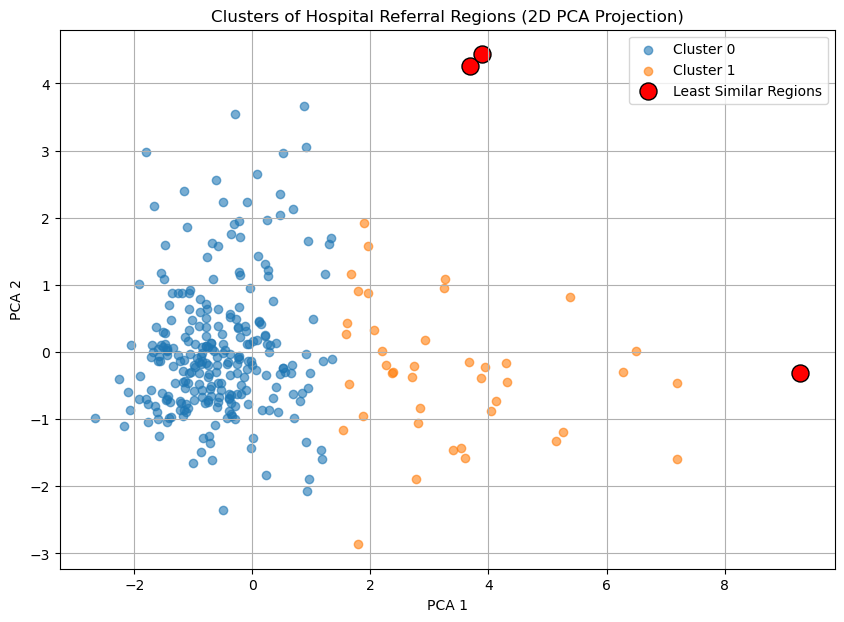

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

# Scatter plot for each cluster
for cluster in range(2):
    cluster_points = X_pca_[df_regions["Cluster"] == cluster, :2]  
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', alpha=0.6)

# Highlight least similar regions
least_similar_indices = df_regions["DistanceToCenter"].nlargest(3).index
least_similar_points = X_pca_[least_similar_indices, :2] 
plt.scatter(least_similar_points[:, 0], least_similar_points[:, 1], 
            color='red', edgecolors='black', s=150, label='Least Similar Regions')

# Labels
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Clusters of Hospital Referral Regions (2D PCA Projection)")
plt.legend()
plt.grid(True)
plt.show()


# PART 3

Identify 10,000 Medicare patients who are involved in anomalous activities. 

In [44]:
Patient_history_samp.head(2)

,id,age,gender,income
0,306535165,65-74,F,24000-31999
1,742231134,65-74,F,48000+


In [45]:
Transaction_coo.head(2)

,id,global_proc_id,count
0,159125,1,1
1,191852,1,1


In [46]:
Global_proc_id.head(2)

,S_No,global_proc_id,DRG_Codes
0,1,1,39
1,2,2,57


In [47]:
Medicare_Charge_Inpatient.head(1)

,DRG_Definition,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payments
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,37861,29228.552734,6902.381348,5514.436035


In [48]:
Medicare_Charge_Inpatient[['DRG_Codes', 'DRG_Description']] = Medicare_Charge_Inpatient['DRG_Definition'].str.split(' - ', n=1, expand=True)
Medicare_Charge_Inpatient['DRG_Codes'] = Medicare_Charge_Inpatient['DRG_Codes'].astype(int)
Medicare_Charge_Inpatient.head(2)

,DRG_Definition,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payments,DRG_Codes,DRG_Description
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,37861,29228.552734,6902.381348,5514.436035,39,EXTRACRANIAL PROCEDURES W/O CC/MCC
1,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,37927,23924.980469,6809.799316,5791.920410,57,DEGENERATIVE NERVOUS SYSTEM DISORDERS W/O MCC


In [49]:
# Merging patient table and transaction table

merge_table= pd.merge(Patient_history_samp,Transaction_coo,on='id',how="inner")

In [50]:
# merging these table with the global proc table

merge_table2 = pd.merge(merge_table,Global_proc_id,on='global_proc_id',how='inner')

In [51]:
# merging with medicare_charge_inpatient table

df = pd.merge(merge_table2,Medicare_Charge_Inpatient,on="DRG_Codes",how='inner')
df.head(2)

,id,age,gender,income,global_proc_id,count,S_No,DRG_Codes,DRG_Definition,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payments,DRG_Description
0,306535165,65-74,F,24000-31999,25,1,25,243,243 - PERMANENT CARDIAC PACEMAKER IMPLANT W CC,35115,67032.054688,18158.527344,16775.830078,PERMANENT CARDIAC PACEMAKER IMPLANT W CC
1,306535165,65-74,F,24000-31999,26,1,26,244,244 - PERMANENT CARDIAC PACEMAKER IMPLANT W/O ...,33639,52954.179688,14061.348633,12555.622070,PERMANENT CARDIAC PACEMAKER IMPLANT W/O CC/MCC


In [52]:
df.drop(columns={"count","S_No","DRG_Definition"},inplace = True)

In [53]:
age_mapping = {'<65': 1, '65-74': 2, '75-84': 3, '85+': 4}
income_mapping = {'<16000 ': 1, '16000-23999': 2, '24000-31999': 3, '32000-47999': 4,'48000+':5}
gender_mapping = {'F':1,",M":2}

In [54]:
df['Age_Group'] = df['age'].map(age_mapping)
df['Income_Level'] = df['income'].map(income_mapping).fillna(1).astype(int)
df['Gender_group'] = df['gender'].map(gender_mapping).fillna(1).astype(int)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1047605 entries, 0 to 1047604
Data columns (total 14 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   id                         1047605 non-null  int64  
 1   age                        1047605 non-null  object 
 2   gender                     1047605 non-null  object 
 3   income                     1047605 non-null  object 
 4   global_proc_id             1047605 non-null  int64  
 5   DRG_Codes                  1047605 non-null  int64  
 6   Total_Discharges           1047605 non-null  int64  
 7   Average_Covered_Charges    1047605 non-null  float64
 8   Average_Total_Payments     1047605 non-null  float64
 9   Average_Medicare_Payments  1047605 non-null  float64
 10  DRG_Description            1047605 non-null  object 
 11  Age_Group                  1047605 non-null  int64  
 12  Income_Level               1047605 non-null  int32  
 13  Gender_group

In [56]:
df.head(1)

,id,age,gender,income,global_proc_id,DRG_Codes,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payments,DRG_Description,Age_Group,Income_Level,Gender_group
0,306535165,65-74,F,24000-31999,25,243,35115,67032.054688,18158.527344,16775.830078,PERMANENT CARDIAC PACEMAKER IMPLANT W CC,2,3,1


In [57]:
# Selecting the features to perform anomaly detection
health_feature = ["Age_Group","Income_Level","Gender_group","DRG_Codes","Total_Discharges","Average_Covered_Charges","Average_Total_Payments","Average_Medicare_Payments"]

# Apply Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination='auto', random_state=42) 
df['Anomaly_Score'] = iso_forest.fit_predict(df[health_feature])

# 1 is non-anomalous
# -1 is anomalous

In [58]:
scores_auto = iso_forest.decision_function(df[health_feature])

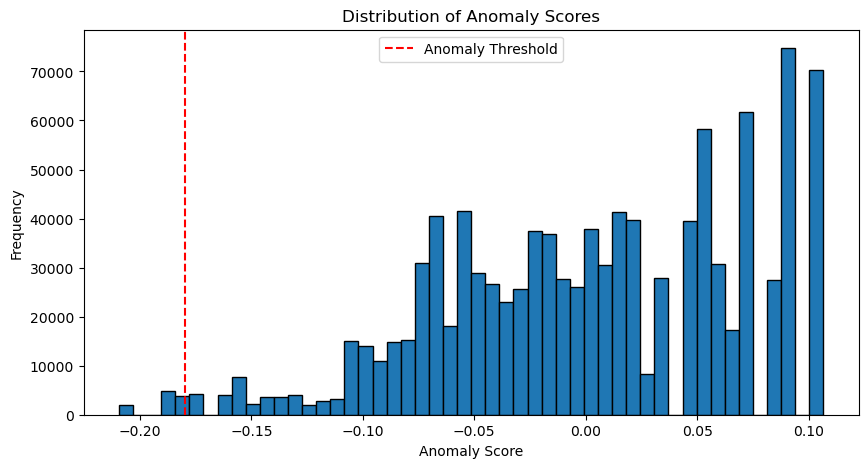

In [59]:
plt.figure(figsize=(10, 5))
plt.hist(scores_auto, bins=50, edgecolor="black")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.title("Distribution of Anomaly Scores")
plt.axvline(x=np.percentile(scores_auto, 1), color="red", linestyle="dashed", label="Anomaly Threshold")
plt.legend()
plt.show()

In [60]:
Anomalous_Patients = df[df["Anomaly_Score"]==-1].nsmallest(10000,'Anomaly_Score')
Anomalous_Patients.shape

(10000, 15)

In [61]:
# ---------------------------visual for ppt=------------------------------

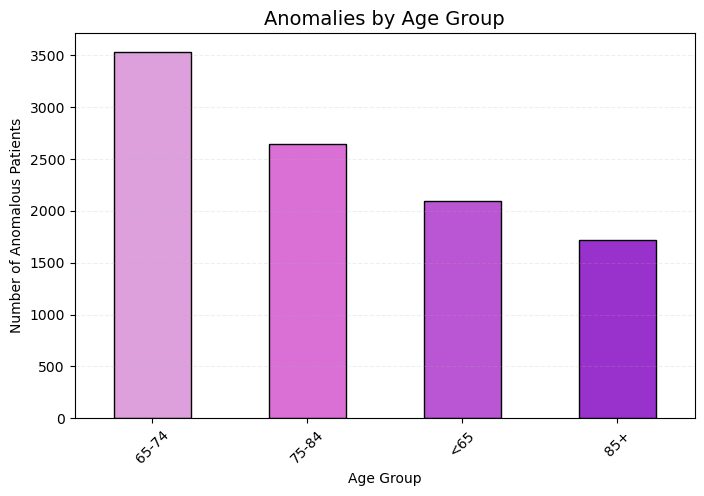

In [62]:
# Bar Chart - Anomalies by Age Group

# Filter anomalies
age_group_counts = Anomalous_Patients['age'].value_counts()

# Define colors for bars
colors = ["plum", "orchid", "mediumorchid", "darkorchid", "purple"]

plt.figure(figsize=(8, 5))  # Slightly larger for better visibility
age_group_counts.plot(kind='bar', color=colors, edgecolor='black')

plt.title("Anomalies by Age Group", fontsize=14)
plt.xlabel("Age Group", fontsize=10)
plt.ylabel("Number of Anomalous Patients", fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.2)  # Light grid for clarity

plt.show()


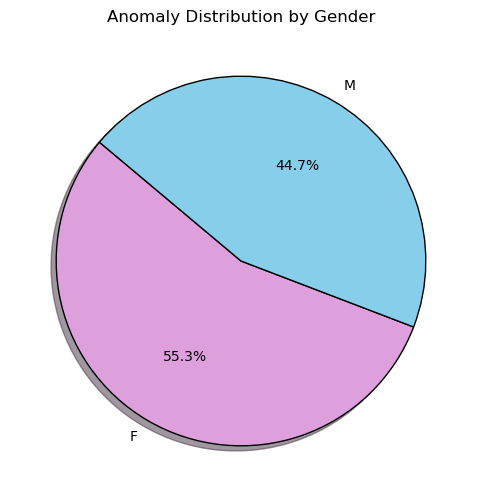

In [63]:
# Count anomalies by gender
gender_counts = Anomalous_Patients['gender'].value_counts()

# Define colors
colors = ["plum", "skyblue"]  # Adjust as needed for better contrast

plt.figure(figsize=(6, 6))
plt.pie(gender_counts, 
        labels=gender_counts.index, 
        autopct='%1.1f%%', 
        startangle=140, 
        colors=colors, 
        shadow=True, 
        wedgeprops={'edgecolor': 'black'})  # Adds black edge for clarity

plt.title("Anomaly Distribution by Gender")
plt.show()


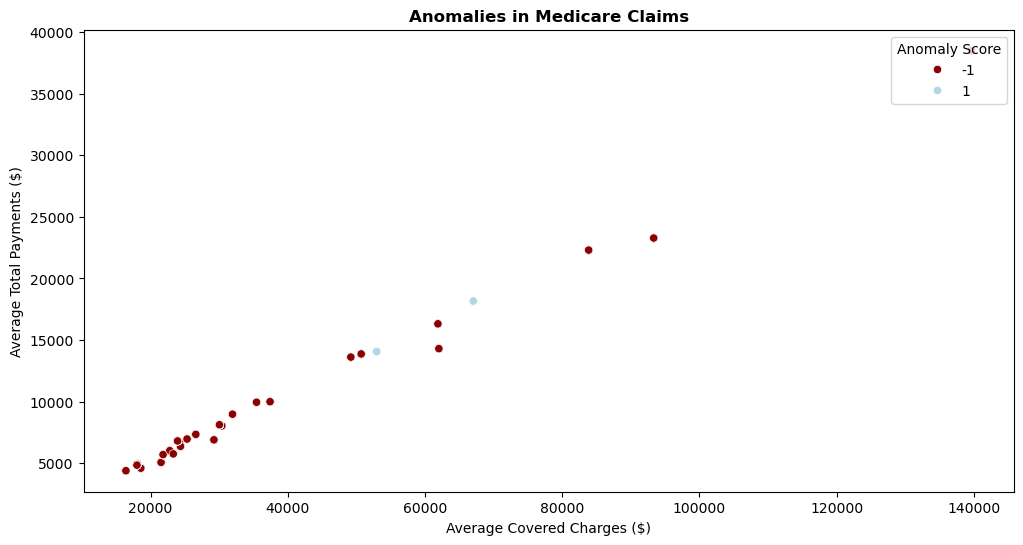

In [64]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=df['Average_Covered_Charges'], 
    y=df['Average_Total_Payments'], 
    hue=df['Anomaly_Score'], 
    palette={1: "lightblue", -1: "darkred"}
)
plt.title("Anomalies in Medicare Claims", fontweight='bold')
plt.xlabel("Average Covered Charges ($)")
plt.ylabel("Average Total Payments ($)")
plt.legend(title="Anomaly Score", loc="upper right")  
plt.show()

# High-Cost Claims Are More Anomalous – Most outliers appear in the mid-to-high charge range ($60,000+).


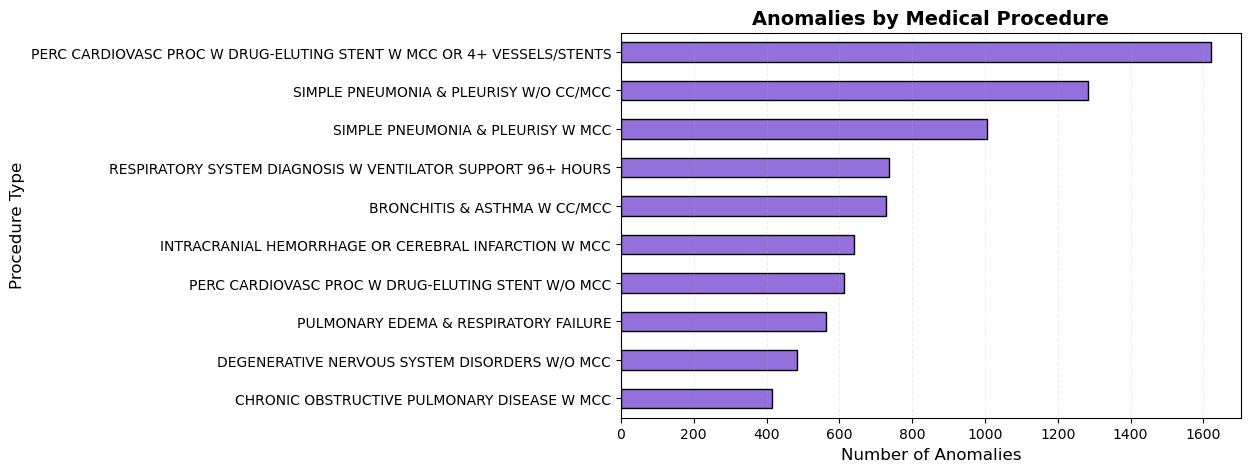

In [65]:
# Bar Chart - Anomalies by Procedure

# Filter anomalies
procedure_counts = Anomalous_Patients['DRG_Description'].value_counts().head(10)  # Top 10 procedures

plt.figure(figsize=(8, 5))
procedure_counts.plot(kind='barh', color = "mediumpurple", edgecolor='black')  # Change color here

plt.title("Anomalies by Medical Procedure", fontsize=14, fontweight='bold')
plt.xlabel("Number of Anomalies", fontsize=12)
plt.ylabel("Procedure Type", fontsize=12)
plt.gca().invert_yaxis()  # Flip chart for better readability
plt.grid(axis='x', linestyle='--', alpha=0.2)

plt.show()

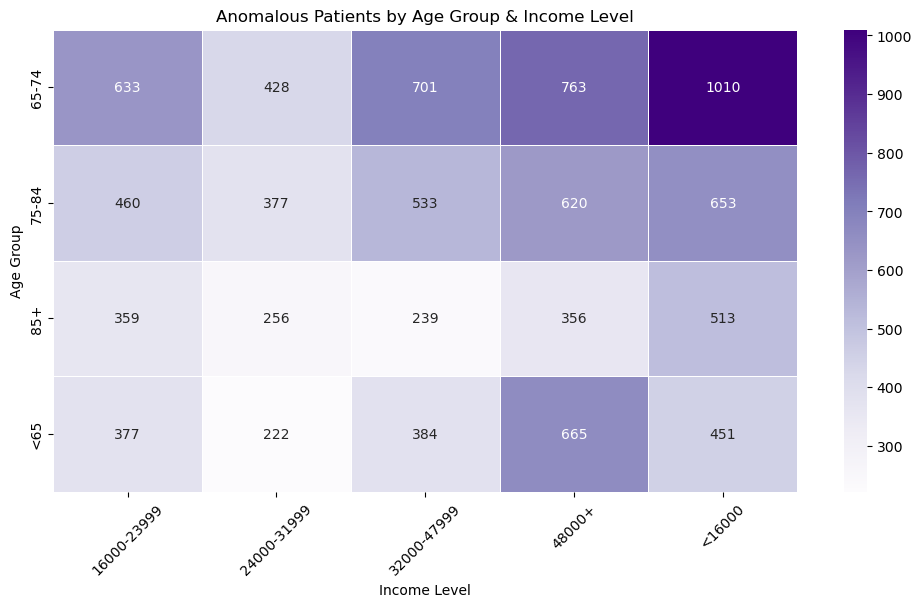

In [66]:
# Income Level vs Age Group for Anomalies
plt.figure(figsize=(12, 6))
# Pivot table for heatmap
heatmap_data = Anomalous_Patients.pivot_table(index="age", columns="income", aggfunc="size", fill_value=0)
sns.heatmap(heatmap_data, cmap="Purples", annot=True, fmt="d", linewidths=0.5, cbar=True)
plt.xlabel("Income Level")
plt.ylabel("Age Group")
plt.title("Anomalous Patients by Age Group & Income Level")
plt.xticks(rotation=45)
plt.show()

### **🔍 Predictive Analytics Problem Statements (Healthcare & Medicare Fraud)**
Since you are working with **Medicare payment data**, you can explore several predictive analytics problems. Here are some problem statements:

---

### **1️⃣ Fraud Detection in Medicare Claims**  
**Problem Statement:**  
Predict whether a **Medicare claim** is fraudulent based on billing patterns, claim amounts, and provider history.  
**Model:** Classification (Logistic Regression, Random Forest, XGBoost, Isolation Forest for anomalies)  
**Dataset Features:**  
- Provider ID  
- Procedure Type  
- Total Charges vs. Medicare Payments  
- Frequency of Claims by Provider  
- Outlier Detection in Billing  

---

### **2️⃣ Predicting Overpriced Procedures**  
**Problem Statement:**  
Predict if a hospital **overcharges for a procedure** compared to industry standards.  
**Model:** Regression (Linear Regression, XGBoost, Random Forest)  
**Dataset Features:**  
- **Average Covered Charges** (Cost to patient)  
- **Average Medicare Payments** (Actual reimbursement)  
- **Total Discharges** (Hospital workload)  
- **Geographical Impact** (Region-wise variations)  

---

### **3️⃣ Identifying Patients at Risk of Readmission**  
**Problem Statement:**  
Predict whether a **Medicare patient** will be readmitted within 30 days after discharge.  
**Model:** Classification (Logistic Regression, Random Forest, Neural Networks)  
**Dataset Features:**  
- Diagnosis & Procedure Codes  
- Total Charges & Payments  
- Previous Readmission History  
- Length of Stay  
- Patient Age & Health Conditions  

---

### **4️⃣ Predicting Patient’s Length of Stay**  
**Problem Statement:**  
Estimate the **number of days** a patient will stay in a hospital based on their condition.  
**Model:** Regression (Random Forest, Decision Trees, XGBoost)  
**Dataset Features:**  
- Admission Type (Emergency, Elective)  
- Diagnosis & Procedures  
- Past Medical History  
- Insurance Coverage  

---

### **5️⃣ Predicting Mortality Rate Based on Hospital Data**  
**Problem Statement:**  
Predict the probability of **patient mortality** based on hospital stay, treatment, and payments.  
**Model:** Classification (Random Forest, Neural Networks)  
**Dataset Features:**  
- Age & Comorbidities  
- Procedure Type  
- Length of Hospital Stay  
- ICU Admission  

---

### **📌 Would You Like to Build One?**  
I can help you:  
✅ **Choose the best problem** for your dataset.  
✅ **Train a model** using ML algorithms.  
✅ **Deploy the model** using **Streamlit** for real-time predictions.  

Which problem do you want to solve? 🚀

# Fraud Detection in Medicare Claims
(Identify whether a Medicare claim is fraudulent based on provider billing patterns.)

In [ ]:
# Feature Engineering
Medicare_Provider_Charge_Inpatient["Overcharging_Ratio"] = Medicare_Provider_Charge_Inpatient["Average_Covered_Charges"] / Medicare_Provider_Charge_Inpatient["Average_Total_Payments_In"]

Medicare_Provider_Charge_Inpatient["Claim_Difference"] = Medicare_Provider_Charge_Inpatient["Average_Covered_Charges"] - Medicare_Provider_Charge_Inpatient["Average_Total_Payments_In"]

In [ ]:
Medicare_Provider_Charge_Inpatient

In [ ]:
# Detecting Anomalies using Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
Medicare_Provider_Charge_Inpatient["Anomaly_Score"] = iso_forest.fit_predict(Medicare_Provider_Charge_Inpatient[["Overcharging_Ratio", "Claim_Difference"]])

In [ ]:
# Mapping -1 as Anomalous (Potential Fraud), 1 as Normal
Medicare_Provider_Charge_Inpatient["Fraud_Label"] = Medicare_Provider_Charge_Inpatient["Anomaly_Score"].map({-1: 1, 1: 0})

In [ ]:
# Train Fraud Detection Model (If labels exist)
if "Fraud_Label" in Medicare_Provider_Charge_Inpatient.columns:
    X = Medicare_Provider_Charge_Inpatient[["Overcharging_Ratio", "Claim_Difference"]]
    y = Medicare_Provider_Charge_Inpatient["Fraud_Label"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_test)

    print("Model Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [ ]:
X_train.tail(20)

In [ ]:
# Creating a pickle file
import pickle
picked_out = open("Classifier.pkl","wb")
pickle.dump(rf_model,picked_out)
picked_out.close()